In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from IPython.display import clear_output
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.models import resnet18,  ResNet18_Weights, VGG16_Weights, vgg16, EfficientNet_B0_Weights, efficientnet_b0
import torchvision.models as models

In [ ]:
class CustomImageFolder(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.samples = []

        for class_folder, label in [("normal", 0), ("glaucoma", 1)]:
            class_folder_path = os.path.join(root, class_folder)
            for image_name in os.listdir(class_folder_path):
                image_path = os.path.join(class_folder_path, image_name)
                self.samples.append((image_path, label))

    def __getitem__(self, index):
        image_path, label = self.samples[index]
        image = Image.open(image_path)

        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.samples)

root_folder = r'C:\Users\Siam\Desktop\Glaucoma datasets\RIM-ONE_DL_images\partitioned_by_hospital'

custom_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CustomImageFolder(os.path.join(root_folder, "training_set"), transform=custom_transform)
test_dataset = CustomImageFolder(os.path.join(root_folder, "test_set"), transform=custom_transform)

train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

train_dataset_extended = [(transforms.functional.hflip(image), label) for image, label in train_dataset]

train_dataset_combined = train_dataset + train_dataset_extended

batch_size = 8
train_loader = DataLoader(train_dataset_combined, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
label_to_count = 1

count = 0

for images, labels in train_loader:
    count += torch.sum(labels == label_to_count).item()

print(f"Number of instances with label {label_to_count}: {count}")

Number of instances with label 1: 184


In [ ]:
label_to_count = 1

count = 0

for images, labels in val_loader:
    count += torch.sum(labels == label_to_count).item()

print(f"Number of instances with label {label_to_count}: {count}")

Number of instances with label 1: 15


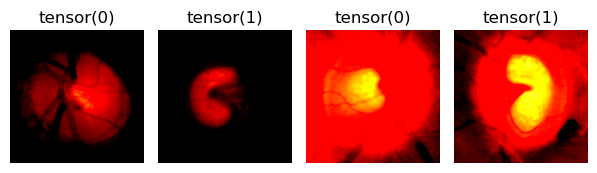

In [ ]:
def show_random_images(data_loader, num_images=4):
    data_iterator = iter(data_loader)
    images, labels = next(data_iterator)

    num_samples = len(images)
    random_indices = np.random.choice(num_samples, num_images, replace=False)

    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(random_indices):
        plt.subplot(2, 8, i + 1)
        image = images[idx].permute(1, 2, 0)
        image = torch.clamp(image, 0.0, 1.0)
        image = image.numpy()
        plt.imshow(image)
        plt.axis('off')
        plt.title(labels[idx])

    plt.tight_layout()
    plt.show()

show_random_images(train_loader)

In [ ]:
class ModifiedVGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(ModifiedVGG16, self).__init__()

        self.vgg16 = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

        for param in self.vgg16.features.parameters():
            param.requires_grad = False

        self.vgg16.classifier[6] = nn.Sequential(
            nn.Linear(4096, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(512, 64),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.vgg16(x)
        return x

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = ModifiedVGG16()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ModifiedVGG16()
model.to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0,2.0]).to(device))
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)

In [ ]:
train_and_plot_metrics(model, train_loader, val_loader, optimizer, criterion, num_epochs, best_accuracy_model_name, best_f1_model_name, lr_decay_epoch)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_scores = []
    val_f1_scores = []

    best_val_f1 = 0.0
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        print("starting epoch " + str(epoch + 1))
        model.train()
        train_loss = 0.0
        total_train = 0
        correct_train = 0

        batch_num = 1

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            batch_num += 1

        train_losses.append(train_loss / len(train_loader))
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='binary', zero_division=1)
        train_f1_scores.append(train_f1)

        model.eval()
        val_loss = 0.0
        total_val = 0
        correct_val = 0
        val_labels = []
        val_predicted = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_labels.extend(labels.cpu().numpy())
                val_predicted.extend(predicted.cpu().numpy())
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        val_f1 = f1_score(val_labels, val_predicted, average='binary', zero_division=1)
        val_f1_scores.append(val_f1)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            model_f1 = model
            # Save the model with the best F1 score
            torch.save(model_f1.state_dict(), best_f1_model_name)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            model_accuracy = model
            # Save the model with the best accuracy
            torch.save(model_accuracy.state_dict(), best_accuracy_model_name)

        if epoch == lr_decay_epoch:
            for param_group in optimizer.param_groups:
                param_group['lr'] /= 10  # Decrease learning rate by dividing by 10

        clear_output()
        print(f'Epoch [{epoch + 1}/{num_epochs}]')
        print(f'Train Loss: {train_losses[-1]:.4f} - Train Accuracy: {train_accuracy:.2f}% - Train F1 Score: {train_f1:.2f}')
        print(f'Validation Loss: {val_losses[-1]:.4f} - Validation Accuracy: {val_accuracy:.2f}% - Validation F1 Score: {val_f1:.2f}')

        # Plot the metrics after each epoch
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.plot(train_losses, label='Train')
        plt.plot(val_losses, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss')

        plt.subplot(132)
        plt.plot(train_accuracies, label='Train')
        plt.plot(val_accuracies, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.title('Accuracy')
        plt.ylim(0.0, 100.0)

        plt.subplot(133)
        plt.plot(train_f1_scores, label='Train')
        plt.plot(val_f1_scores, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.title('F1 Score')
        plt.ylim(0.0, 1.0)

        plt.show()

Epoch [10/10]
Train Loss: 0.1550 - Train Accuracy: 97.00% - Train F1 Score: 1.00
Validation Loss: 0.1768 - Validation Accuracy: 91.11% - Validation F1 Score: 0.88


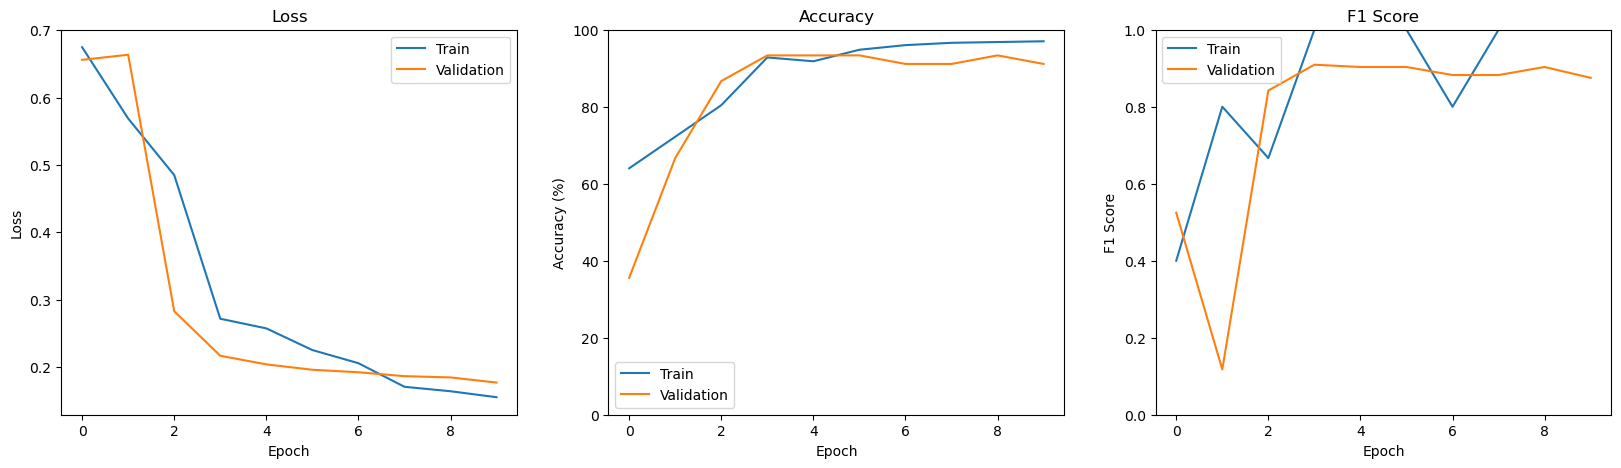

In [ ]:
train_and_plot_metrics(model, train_loader, val_loader, optimizer, criterion, num_epochs = 10,
                       best_accuracy_model_name="C:\\Users\\Siam\\Desktop\\models\\vgg_acc.pth",
                       best_f1_model_name="C:\\Users\\Siam\\Desktop\\models\\vgg_f1.pth", lr_decay_epoch=2)

In [ ]:
highest_acc_vgg = ModifiedVGG16()
highest_acc_vgg.load_state_dict(torch.load("C:\\Users\\Siam\\Desktop\\models\\vgg_accuracy.pth"))
highest_f1_vgg = ModifiedVGG16()
highest_f1_vgg.load_state_dict(torch.load("C:\\Users\\Siam\\Desktop\\models\\vgg_f1.pth"))

<All keys matched successfully>

In [ ]:
true_labels = []
predictions = []

highest_acc_vgg.eval()
highest_acc_vgg.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = highest_acc_vgg(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predictions.extend(predicted.tolist())
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

accuracy = accuracy_score(true_labels, predictions)
f1_weighted = f1_score(true_labels, predictions, average='weighted')

f1_macro = f1_score(true_labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")
print(f"Macro F1 Score: {f1_macro:.2f}")
highest_acc_vgg.to("cpu")
print("")

Accuracy: 0.81
Weighted F1 Score: 0.80
Macro F1 Score: 0.77



In [ ]:
true_labels = []
predictions = []

highest_f1_vgg.eval()
highest_f1_vgg.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = highest_f1_vgg(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predictions.extend(predicted.tolist())
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

accuracy = accuracy_score(true_labels, predictions)
f1_weighted = f1_score(true_labels, predictions, average='weighted')

f1_macro = f1_score(true_labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")
print(f"Macro F1 Score: {f1_macro:.2f}")
highest_f1_vgg.to("cpu")
print("")

Accuracy: 0.75
Weighted F1 Score: 0.76
Macro F1 Score: 0.73



In [ ]:
true_labels = []
predictions = []

model.eval()
model.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predictions.extend(predicted.tolist())
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

accuracy = accuracy_score(true_labels, predictions)
f1_weighted = f1_score(true_labels, predictions, average='weighted')

f1_macro = f1_score(true_labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")
print(f"Macro F1 Score: {f1_macro:.2f}")
model.to("cpu")
print("")

Accuracy: 0.77
Weighted F1 Score: 0.77
Macro F1 Score: 0.74



In [ ]:
class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ModifiedResNet18, self).__init__()
        self.resnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        for param in self.resnet18.parameters():
            param.requires_grad = False

        self.resnet18.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.resnet18(x)
        return x

In [ ]:
model = ModifiedResNet18()
model.to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0,2.0]).to(device))
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.5)

Epoch [20/20]
Train Loss: 0.5898 - Train Accuracy: 73.20% - Train F1 Score: 0.00
Validation Loss: 0.5386 - Validation Accuracy: 84.44% - Validation F1 Score: 0.80


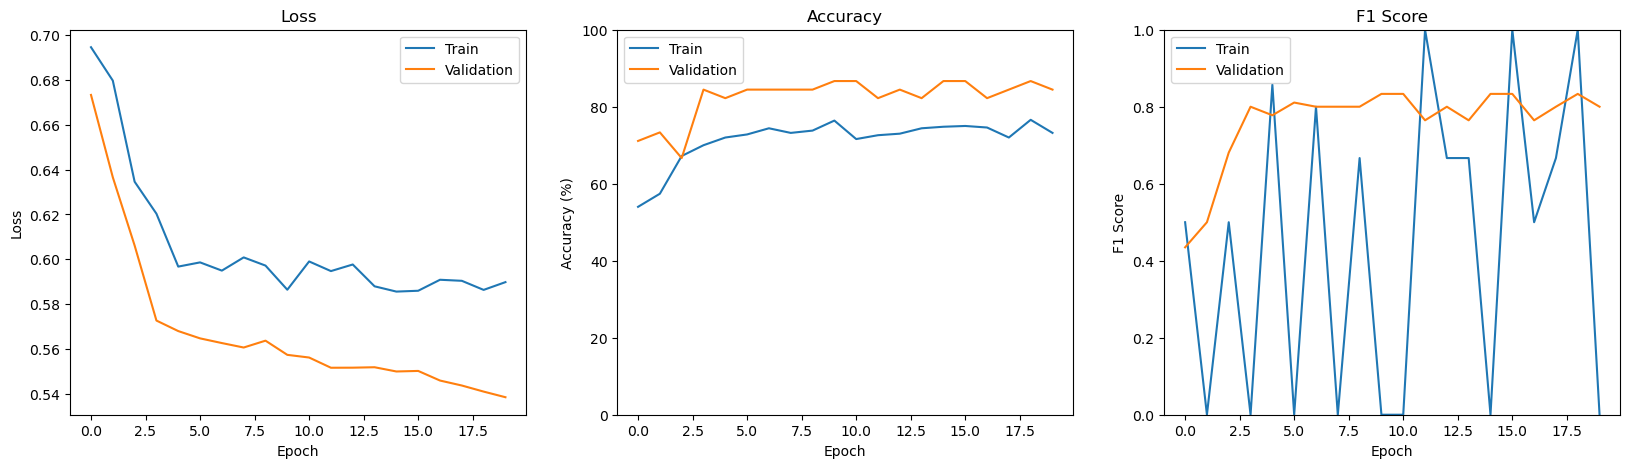

In [ ]:
train_and_plot_metrics(model, train_loader, val_loader, optimizer, criterion, num_epochs = 20,
                       best_accuracy_model_name="C:\\Users\\Siam\\Desktop\\models\\resnet_acc.pth",
                       best_f1_model_name="C:\\Users\\Siam\\Desktop\\models\\resnet_f1.pth", lr_decay_epoch=3)

In [ ]:
highest_acc_rn = ModifiedResNet18()
highest_acc_rn.load_state_dict(torch.load("C:\\Users\\Siam\\Desktop\\models\\resnet_acc.pth"))
highest_f1_rn = ModifiedResNet18()
highest_f1_rn.load_state_dict(torch.load("C:\\Users\\Siam\\Desktop\\models\\resnet_f1.pth"))

In [ ]:
true_labels = []
predictions = []

highest_acc_rn.eval()
highest_acc_rn.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = highest_acc_rn(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predictions.extend(predicted.tolist())
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

accuracy = accuracy_score(true_labels, predictions)
f1_weighted = f1_score(true_labels, predictions, average='weighted')

f1_macro = f1_score(true_labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")
print(f"Macro F1 Score: {f1_macro:.2f}")
highest_acc_rn.to("cpu")
print("")

Accuracy: 0.68
Weighted F1 Score: 0.69
Macro F1 Score: 0.65



In [ ]:
true_labels = []
predictions = []

highest_f1_rn.eval()
highest_f1_rn.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = highest_f1_rn(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predictions.extend(predicted.tolist())
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

accuracy = accuracy_score(true_labels, predictions)
f1_weighted = f1_score(true_labels, predictions, average='weighted')

f1_macro = f1_score(true_labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")
print(f"Macro F1 Score: {f1_macro:.2f}")
highest_f1_rn.to("cpu")
print("")

Accuracy: 0.68
Weighted F1 Score: 0.69
Macro F1 Score: 0.65



In [ ]:
true_labels = []
predictions = []

model.eval()
model.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predictions.extend(predicted.tolist())
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

accuracy = accuracy_score(true_labels, predictions)
f1_weighted = f1_score(true_labels, predictions, average='weighted')

f1_macro = f1_score(true_labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")
print(f"Macro F1 Score: {f1_macro:.2f}")
model.to("cpu")
print("")

Accuracy: 0.65
Weighted F1 Score: 0.67
Macro F1 Score: 0.63



In [ ]:
student1 = ModifiedResNet18()

In [ ]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0,2.0]).to(device))
optimizer = optim.Adam(student1.parameters(), lr=0.0001, weight_decay=0.1)

In [ ]:
def train_knowledge_distillation(teacher, student, train_loader, val_loader, optimizer, criterion, num_epochs, best_accuracy_model_name, best_f1_model_name, lr_decay_epoch, T, soft_target_loss_weight, ce_loss_weight):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_scores = []
    val_f1_scores = []

    best_val_f1 = 0.0
    best_val_accuracy = 0.0

    teacher.to(device)
    student.to(device)

    for epoch in range(num_epochs):
        print("starting epoch " + str(epoch + 1))
        student.train()
        train_loss = 0.0
        total_train = 0
        correct_train = 0

        batch_num = 1

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass with the teacher model
            with torch.no_grad():
                teacher_logits = teacher(inputs)

            # Forward pass with the student model
            student_logits = student(inputs)

            soft_targets = nn.functional.softmax(teacher_logits / T, dim=-1)
            soft_prob = nn.functional.log_softmax(student_logits / T, dim=-1)

            soft_targets_loss = -torch.sum(soft_targets * soft_prob) / soft_prob.size()[0] * (T**2)

            label_loss = criterion(student_logits, labels)

            loss = soft_target_loss_weight * soft_targets_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            _, predicted = torch.max(student_logits.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            batch_num += 1

        train_losses.append(train_loss / len(train_loader))
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_f1 = f1_score(labels.cpu().numpy(), predicted.cpu().numpy(), average='binary', zero_division=1)
        train_f1_scores.append(train_f1)

        student.eval()
        val_loss = 0.0
        total_val = 0
        correct_val = 0
        val_labels = []
        val_predicted = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = student(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_labels.extend(labels.cpu().numpy())
                val_predicted.extend(predicted.cpu().numpy())
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracy = 100 * correct_val / total_val
        val_accuracies.append(val_accuracy)
        val_f1 = f1_score(val_labels, val_predicted, average='binary', zero_division=1)
        val_f1_scores.append(val_f1)

        if val_f1 >= best_val_f1:
            best_val_f1 = val_f1
            best_f1_model = student
            # Save the model with the best F1 score
            torch.save(best_f1_model.state_dict(), best_f1_model_name)

        if val_accuracy >= best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_accuracy_model = student
            # Save the model with the best accuracy
            torch.save(best_accuracy_model.state_dict(), best_accuracy_model_name)

        if epoch == lr_decay_epoch:
            for param_group in optimizer.param_groups:
                param_group['lr'] /= 10  # Decrease learning rate by dividing by 10

        clear_output()
        print(f'Epoch [{epoch + 1}/{num_epochs}]')
        print(f'Train Loss: {train_losses[-1]:.4f} - Train Accuracy: {train_accuracy:.2f}% - Train F1 Score: {train_f1:.2f}')
        print(f'Validation Loss: {val_losses[-1]:.4f} - Validation Accuracy: {val_accuracy:.2f}% - Validation F1 Score: {val_f1:.2f}')

        # Plot the metrics after each epoch
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.plot(train_losses, label='Train')
        plt.plot(val_losses, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss')

        plt.subplot(132)
        plt.plot(train_accuracies, label='Train')
        plt.plot(val_accuracies, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.title('Accuracy')
        plt.ylim(0.0, 100.0)

        plt.subplot(133)
        plt.plot(train_f1_scores, label='Train')
        plt.plot(val_f1_scores, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.title('F1 Score')
        plt.ylim(0.0, 1.0)

        plt.show()

Epoch [10/10]
Train Loss: 8.8001 - Train Accuracy: 78.40% - Train F1 Score: 0.67
Validation Loss: 0.4312 - Validation Accuracy: 84.44% - Validation F1 Score: 0.81


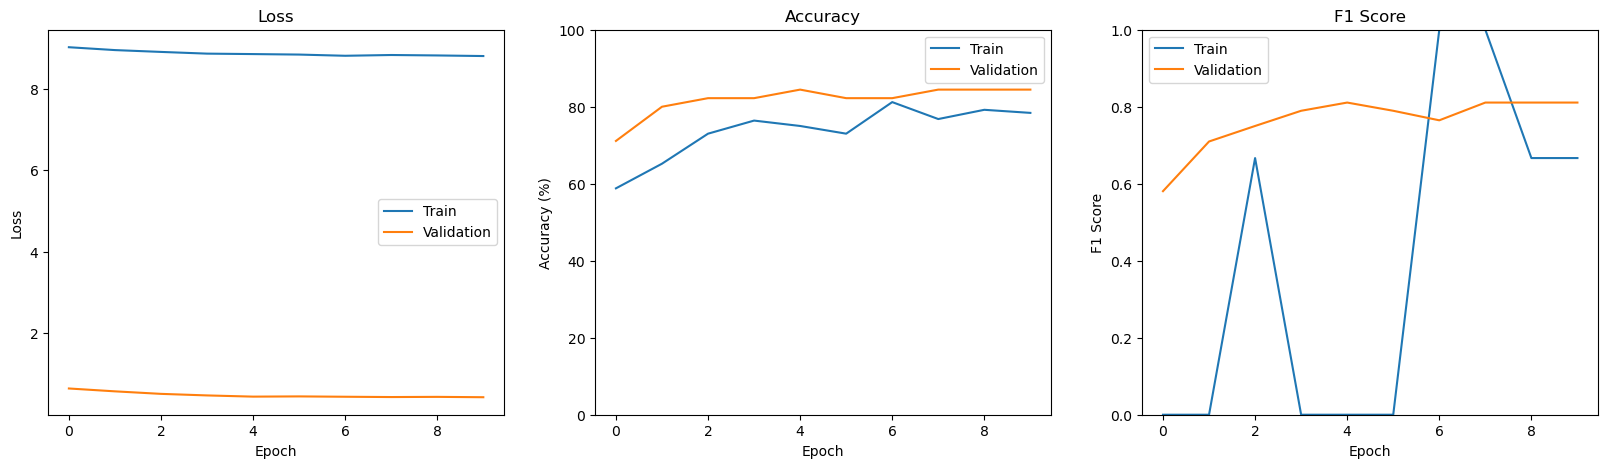

In [ ]:
train_knowledge_distillation(teacher=highest_acc_vgg, student=student1, train_loader=train_loader,
                             val_loader=val_loader, optimizer=optimizer, criterion=criterion, num_epochs=10,
                             best_accuracy_model_name="C:\\Users\\Siam\\Desktop\\models\\s1_acc.pth",
                             best_f1_model_name="C:\\Users\\Siam\\Desktop\\models\\s1_f1.pth", lr_decay_epoch=4,
                             T=5, soft_target_loss_weight=0.5, ce_loss_weight=0.5)

In [ ]:
s1_acc = ModifiedResNet18()
s1_acc.load_state_dict(torch.load("C:\\Users\\Siam\\Desktop\\models\\s1_acc.pth"))
s1_f1 = ModifiedResNet18()
s1_f1.load_state_dict(torch.load("C:\\Users\\Siam\\Desktop\\models\\s1_f1.pth"))

<All keys matched successfully>

In [ ]:
true_labels = []
predictions = []

s1_acc.eval()
s1_acc.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = s1_acc(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predictions.extend(predicted.tolist())
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

accuracy = accuracy_score(true_labels, predictions)
f1_weighted = f1_score(true_labels, predictions, average='weighted')

f1_macro = f1_score(true_labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")
print(f"Macro F1 Score: {f1_macro:.2f}")
s1_acc.to("cpu")
print("")

Accuracy: 0.71
Weighted F1 Score: 0.72
Macro F1 Score: 0.69



In [ ]:
true_labels = []
predictions = []

s1_f1.eval()
s1_f1.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = s1_f1(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predictions.extend(predicted.tolist())
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

accuracy = accuracy_score(true_labels, predictions)
f1_weighted = f1_score(true_labels, predictions, average='weighted')

f1_macro = f1_score(true_labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")
print(f"Macro F1 Score: {f1_macro:.2f}")
s1_f1.to("cpu")
print("")

Accuracy: 0.71
Weighted F1 Score: 0.72
Macro F1 Score: 0.69



In [ ]:
class ModifiedEfficientNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ModifiedEfficientNet, self).__init__()

        self.base_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

        for param in self.base_model.parameters():
            param.requires_grad = False

        in_features = self.base_model.classifier[1].in_features
        self.base_model.classifier = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(128, 16),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        x = self.base_model(x)
        return x


In [ ]:
model = ModifiedEfficientNet()
model.to(device)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0,2.0]).to(device))
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)

Epoch [20/20]
Train Loss: 0.6060 - Train Accuracy: 74.20% - Train F1 Score: 0.67
Validation Loss: 0.5845 - Validation Accuracy: 88.89% - Validation F1 Score: 0.86


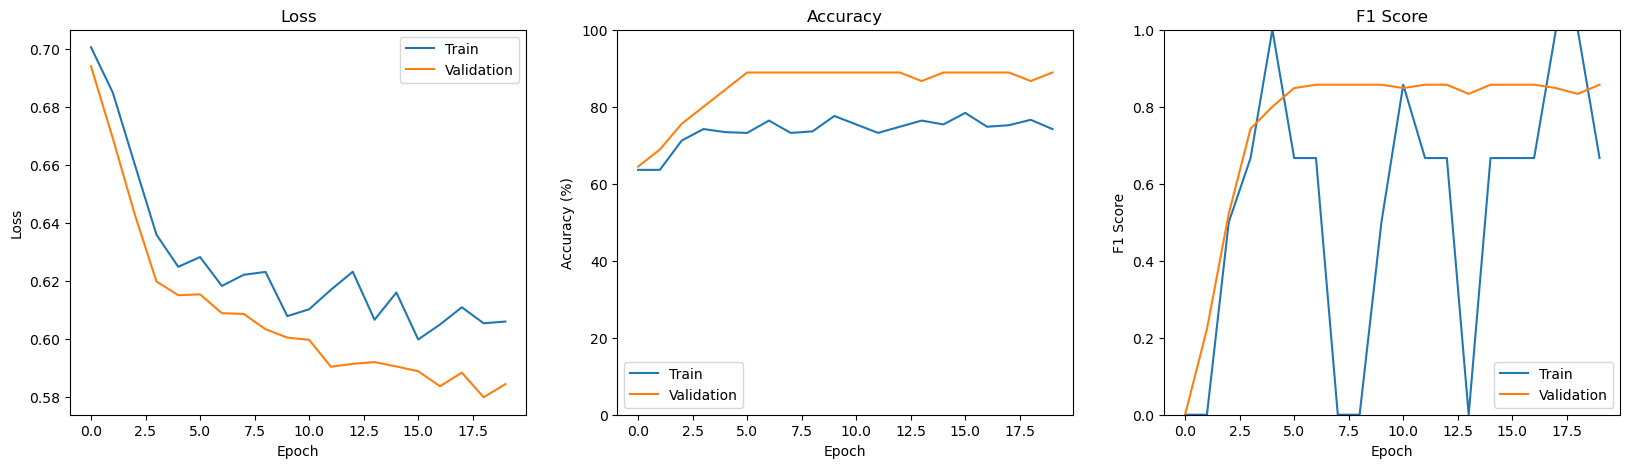

In [ ]:
train_and_plot_metrics(model, train_loader, val_loader, optimizer, criterion, num_epochs = 20,
                       best_accuracy_model_name="C:\\Users\\Siam\\Desktop\\models\\en_acc.pth",
                       best_f1_model_name="C:\\Users\\Siam\\Desktop\\models\\en_f1.pth", lr_decay_epoch=3)

In [ ]:
highest_acc_en = ModifiedEfficientNet()
highest_acc_en.load_state_dict(torch.load("C:\\Users\\Siam\\Desktop\\models\\en_acc.pth"))
highest_f1_en = ModifiedEfficientNet()
highest_f1_en.load_state_dict(torch.load("C:\\Users\\Siam\\Desktop\\models\\en_f1.pth"))

<All keys matched successfully>

In [ ]:
true_labels = []
predictions = []

highest_acc_en.eval()
highest_acc_en.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = highest_acc_en(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predictions.extend(predicted.tolist())
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

accuracy = accuracy_score(true_labels, predictions)
f1_weighted = f1_score(true_labels, predictions, average='weighted')

f1_macro = f1_score(true_labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")
print(f"Macro F1 Score: {f1_macro:.2f}")
highest_acc_en.to("cpu")
print("")

Accuracy: 0.63
Weighted F1 Score: 0.64
Macro F1 Score: 0.62



In [ ]:
true_labels = []
predictions = []

highest_f1_en.eval()
highest_f1_en.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = highest_f1_en(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predictions.extend(predicted.tolist())
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

accuracy = accuracy_score(true_labels, predictions)
f1_weighted = f1_score(true_labels, predictions, average='weighted')

f1_macro = f1_score(true_labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")
print(f"Macro F1 Score: {f1_macro:.2f}")
highest_f1_en.to("cpu")
print("")

Accuracy: 0.63
Weighted F1 Score: 0.64
Macro F1 Score: 0.62



In [ ]:
student2 = ModifiedEfficientNet()

In [ ]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0,2.0]).to(device))
optimizer = optim.Adam(student2.parameters(), lr=0.0001, weight_decay=0.1)

Epoch [17/20]
Train Loss: 4.7713 - Train Accuracy: 72.60% - Train F1 Score: 1.00
Validation Loss: 0.5845 - Validation Accuracy: 88.89% - Validation F1 Score: 0.86


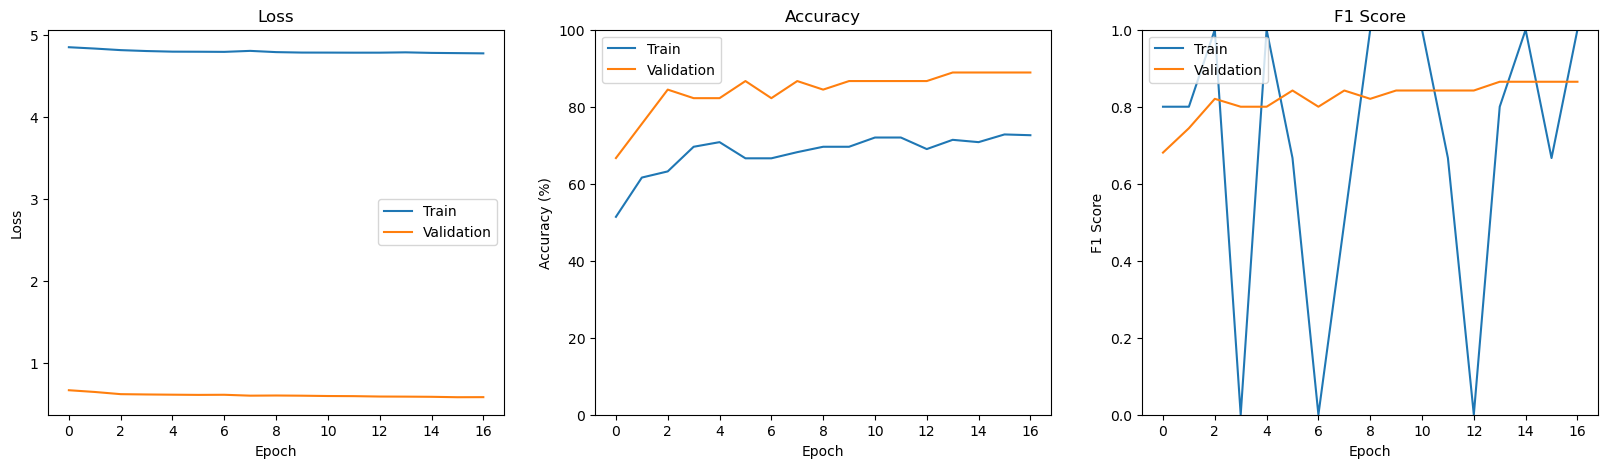

starting epoch 18


KeyboardInterrupt: ignored

In [ ]:
train_knowledge_distillation(teacher=highest_acc_vgg, student=student2, train_loader=train_loader,
                             val_loader=val_loader, optimizer=optimizer, criterion=criterion, num_epochs=20,
                             best_accuracy_model_name="C:\\Users\\Siam\\Desktop\\models\\s2_acc.pth",
                             best_f1_model_name="C:\\Users\\Siam\\Desktop\\models\\s2_f1.pth", lr_decay_epoch=2,
                             T=3, soft_target_loss_weight=0.5, ce_loss_weight=0.5)

In [ ]:
s2_acc = ModifiedEfficientNet()
s2_acc.load_state_dict(torch.load("C:\\Users\\Siam\\Desktop\\models\\s2_acc.pth"))
s2_f1 = ModifiedEfficientNet()
s2_f1.load_state_dict(torch.load("C:\\Users\\Siam\\Desktop\\models\\s2_f1.pth"))

<All keys matched successfully>

In [ ]:
true_labels = []
predictions = []

s2_acc.eval()
s2_acc.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = s2_acc(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predictions.extend(predicted.tolist())
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

accuracy = accuracy_score(true_labels, predictions)
f1_weighted = f1_score(true_labels, predictions, average='weighted')

f1_macro = f1_score(true_labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")
print(f"Macro F1 Score: {f1_macro:.2f}")
s2_acc.to("cpu")
print("")

Accuracy: 0.76
Weighted F1 Score: 0.75
Macro F1 Score: 0.70



In [ ]:
true_labels = []
predictions = []

s2_f1.eval()
s2_f1.to(device)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = s2_f1(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.tolist())
        predictions.extend(predicted.tolist())
        inputs, labels = inputs.to("cpu"), labels.to("cpu")

accuracy = accuracy_score(true_labels, predictions)
f1_weighted = f1_score(true_labels, predictions, average='weighted')

f1_macro = f1_score(true_labels, predictions, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Weighted F1 Score: {f1_weighted:.2f}")
print(f"Macro F1 Score: {f1_macro:.2f}")
s2_f1.to("cpu")
print("")

Accuracy: 0.76
Weighted F1 Score: 0.75
Macro F1 Score: 0.70



In [ ]:
s1_acc.to(device)
s2_acc.to(device)

s1_acc.eval()
s2_acc.eval()

ensemble_predictions = []
true_labels = []

alpha = 0.9

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        true_labels.extend(labels.cpu().numpy())

        s1_outputs = torch.sigmoid(s1_acc(inputs))
        s2_outputs = torch.sigmoid(s2_acc(inputs))

        weighted_probs = (1 - alpha) * s1_outputs + alpha * s2_outputs

        predicted = torch.argmax(weighted_probs, dim=1)
        ensemble_predictions.extend(predicted.cpu().numpy())

ensemble_accuracy = accuracy_score(true_labels, ensemble_predictions)
ensemble_f1_weighted = f1_score(true_labels, ensemble_predictions, average='weighted')
ensemble_f1_macro = f1_score(true_labels, ensemble_predictions, average='macro')

print(f"Ensemble Accuracy: {ensemble_accuracy:.2f}")
print(f"Ensemble Weighted F1 Score: {ensemble_f1_weighted:.2f}")
print(f"Ensemble Macro F1 Score: {ensemble_f1_macro:.2f}")

Ensemble Accuracy: 0.79
Ensemble Weighted F1 Score: 0.78
Ensemble Macro F1 Score: 0.74
